In [2]:
from ortools.sat.python import cp_model
import numpy as np
import math
import random
import matplotlib.pyplot as plt

In [13]:
class VarArraySolutionPrinter(cp_model.CpSolverSolutionCallback):
    """Print intermediate solutions."""

    def __init__(self, x,z,S,n):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.__n = n
        self.__S = S
        self.__x = x
        self.__z = z

        self.__solution_count = 0

    def on_solution_callback(self):
        self.__solution_count += 1

        print(f'Solution {self.__solution_count}:', \
              ([i for i,s in self.__z.keys() if self.Value(self.__z[i,s]) == 1]))
        
        # Printing each stage of the solution
        sol = [self.Value(self.__x[i,s]) for s in self.__S for i in self.__S]
        sol = np.reshape(sol,(self.__n**2,self.__n,self.__n))
        
        for i in range(len(sol)):
            if i == 0:
                plt.imshow(sol[i], cmap="binary_r")
                plt.axis('off')
                plt.show()
            elif i > 0 and not(np.array_equal(sol[i-1],sol[i])): 
                plt.imshow(sol[i], cmap="binary_r")
                plt.axis('off')
                plt.show()
                
    def solution_count(self):
        return self.__solution_count

In [14]:
# Function to create random grids of size n x n
def RandomGrid(n):
    '''
    n = Size of grid.
    '''
    # Random grid lights
    num = random.randint(1,n**2)
    lights = random.sample(range(0,n**2),num)
    print('Light(s) chosen: \n', sorted(lights))

    # Creating grid
    changes = [0,1,-1,n,-n]
    grid = np.zeros((1,n**2))[0]
    for i in sorted(lights):
        for j in changes:
            if i+j in range(n**2):
                if any([j == 1 and (i+j) % n == 0, j == -1 and i % n == 0]):
                    continue
                elif grid[i+j] == 0:
                    grid[i+j] = 1
                else:
                    grid[i+j] = 0          
    grid = grid.astype(int)
    print('Grid: \n',np.reshape(grid,(n,n)),'\n')
    return grid

Light(s) chosen: 
 [0, 1, 2, 4, 7, 8, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23]
Grid: 
 [[0 1 1 1 1]
 [1 0 0 1 0]
 [1 0 0 0 1]
 [1 0 1 0 1]
 [1 0 0 1 1]] 

Solution 1: [2, 3, 7, 8, 10, 11, 12, 14, 15, 16, 17, 18, 22, 24]


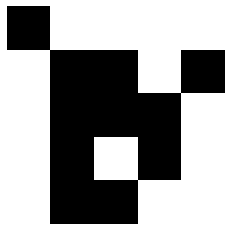

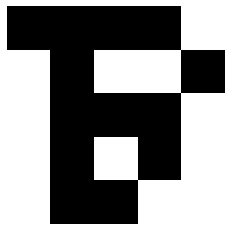

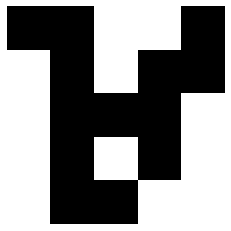

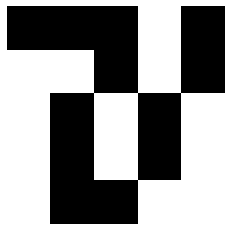

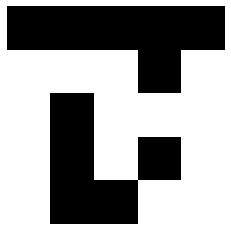

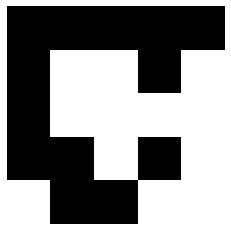

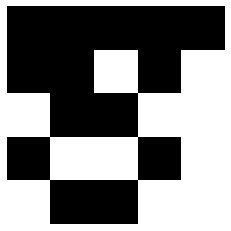

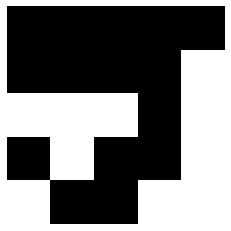

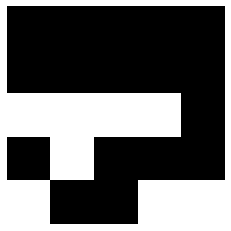

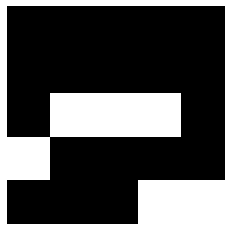

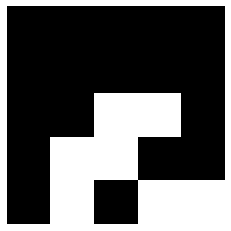

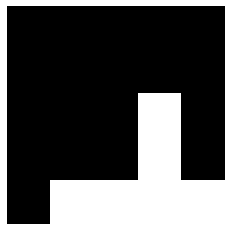

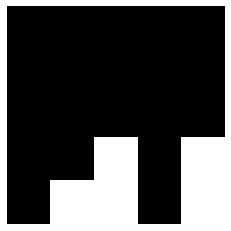

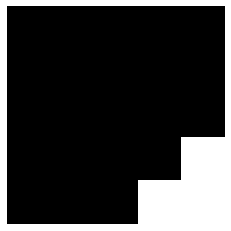

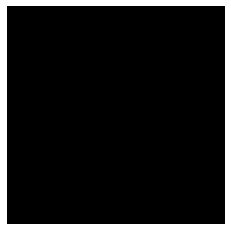

Solution 2: [0, 1, 2, 4, 7, 8, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23]


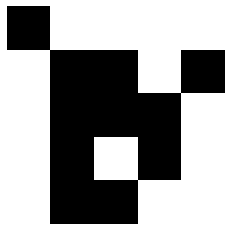

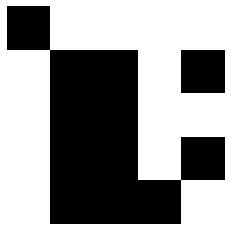

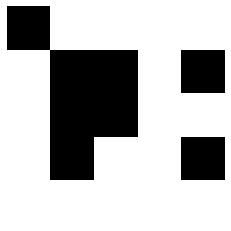

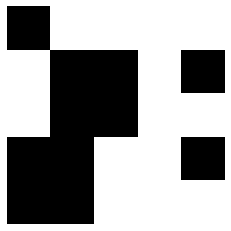

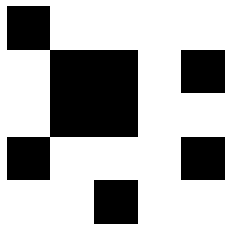

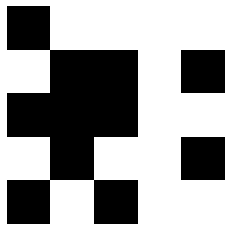

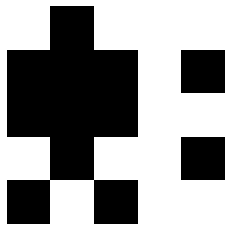

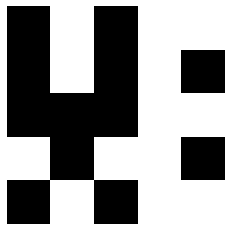

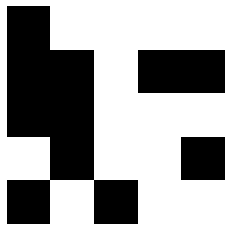

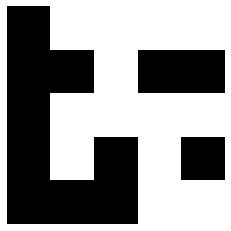

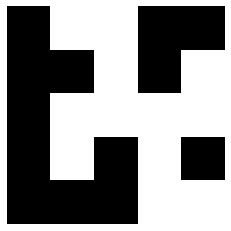

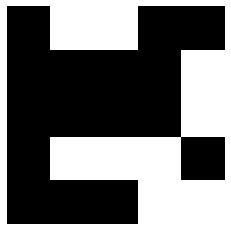

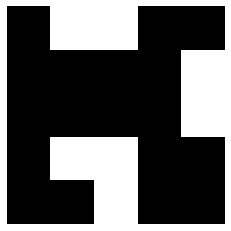

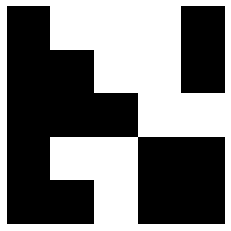

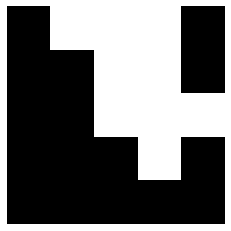

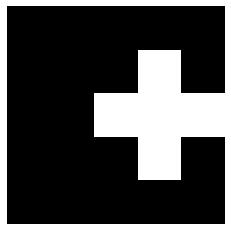

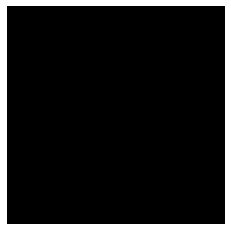

Solution 3: [0, 3, 4, 5, 8, 9, 10, 11, 12, 14, 16, 18, 19, 20]


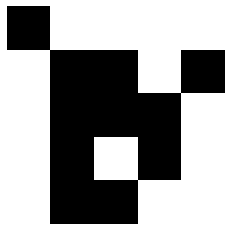

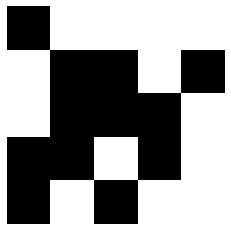

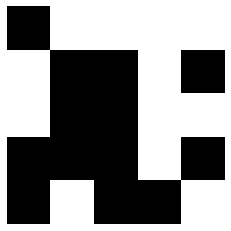

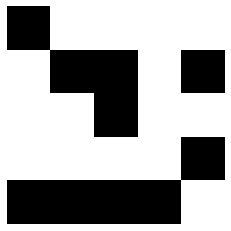

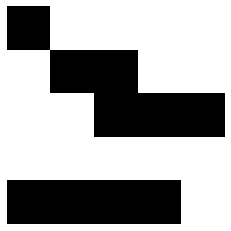

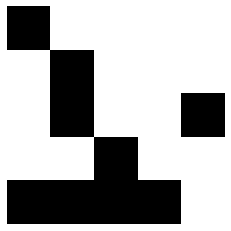

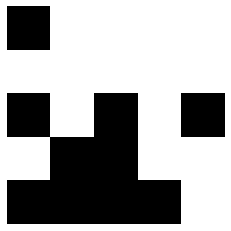

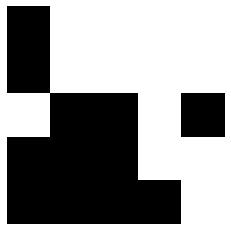

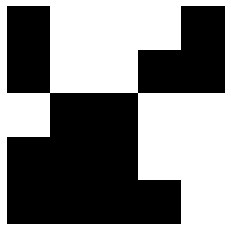

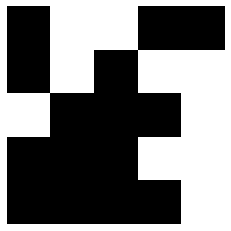

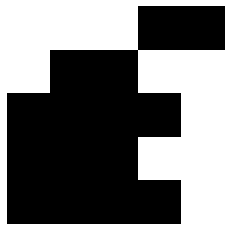

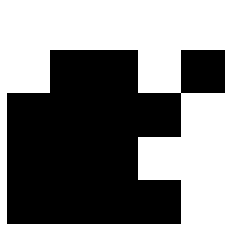

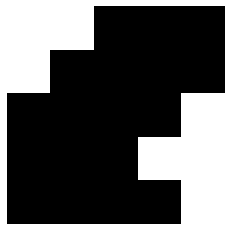

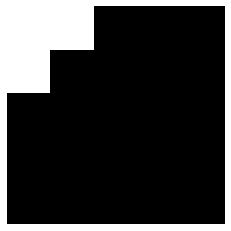

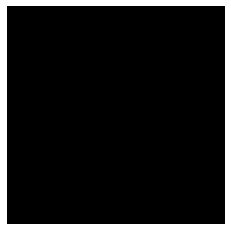

Solution 4: [0, 1, 2, 4, 7, 8, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23]


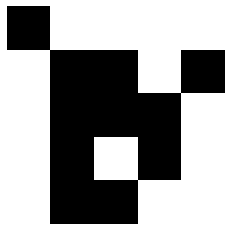

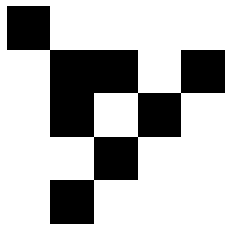

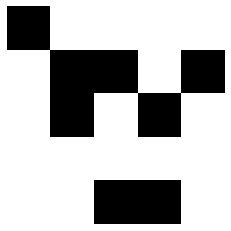

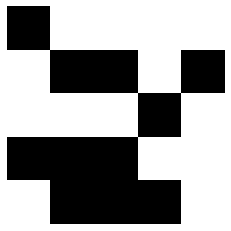

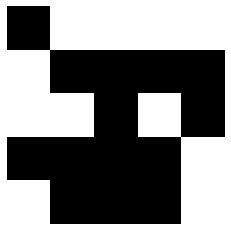

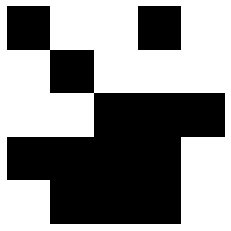

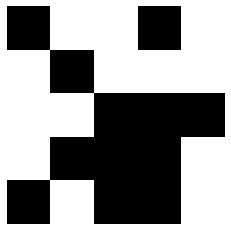

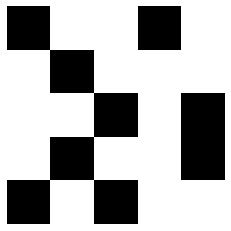

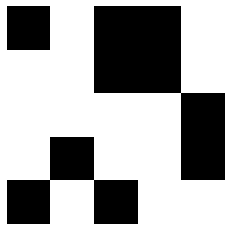

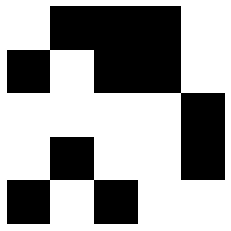

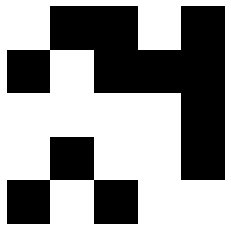

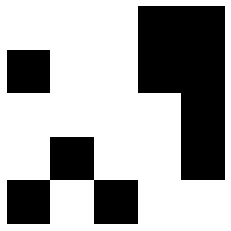

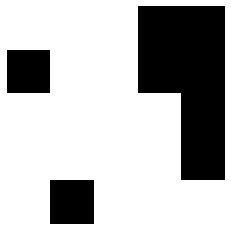

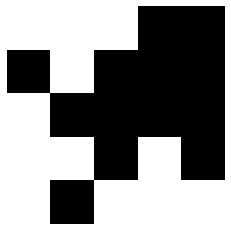

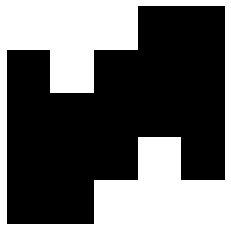

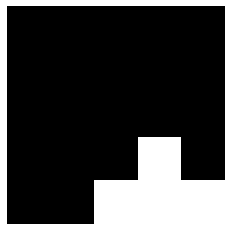

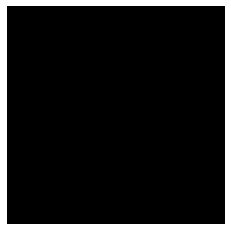

Solution 5: [2, 3, 7, 8, 10, 11, 12, 14, 15, 16, 17, 18, 22, 24]


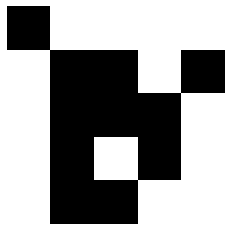

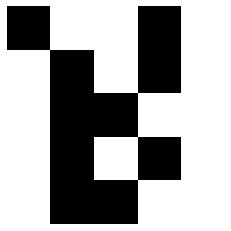

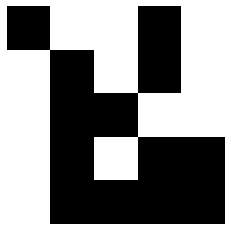

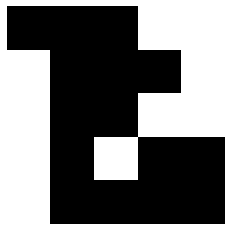

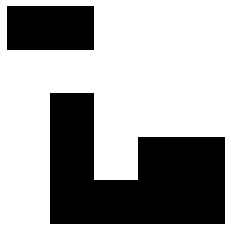

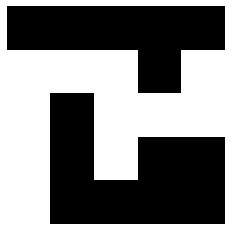

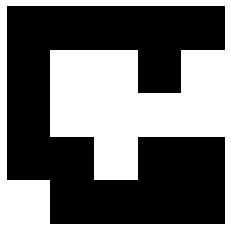

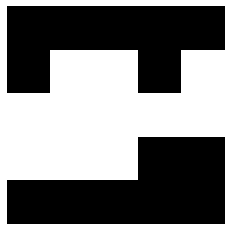

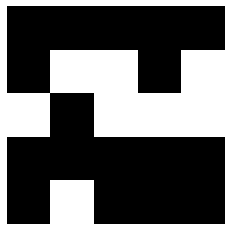

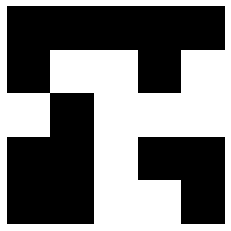

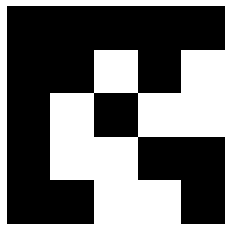

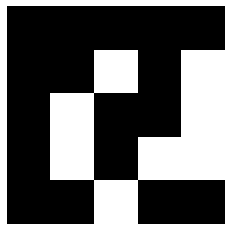

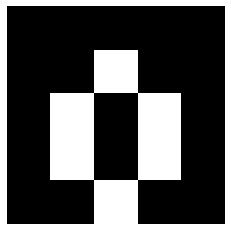

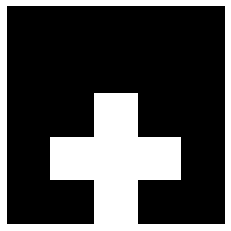

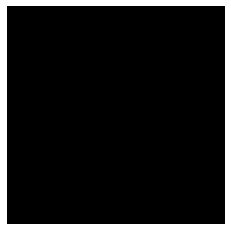

Status = OPTIMAL


In [17]:
#random.seed(43210)

def LightsOut(grid = None, rand_grid_size = None):

    '''
    Either input a grid or select a random grid to pass.

    grid: must be a square (rows = cols).
    rand_grid_size: integer value > 0
    '''

    if rand_grid_size != None:
        grid = RandomGrid(rand_grid_size)

    n = int(math.sqrt(len(grid)))

    # Creates the model and set solver
    model = cp_model.CpModel()
    solver = cp_model.CpSolver()

    # Stages
    S = range(n**2)

    # Each cell in the grid
    x = {(i,s):model.NewBoolVar(f"x_{i}_{s}") for i in S for s in S}
    # Light that is switched
    z = {(i,s):model.NewBoolVar(f"z_{i}_{s}") for i in S for s in S}
    # Termination Condition (0 = continue, 1 = terminate)
    term = {(s):model.NewBoolVar(f"term_{s}") for s in S}

    changes = [0, 1, -1, n, -n]

    model.AddAtLeastOne([term[s] for s in S])

    for i in S:
        model.Add(x[i,0] == grid[i])
        model.AddAtMostOne([z[i,s] for s in S])
    
    for s in S:
        model.Add(sum(x[i,s] for i in S) == 0).OnlyEnforceIf(term[s])
        model.Add(sum(x[i,s] for i in S) != 0).OnlyEnforceIf(term[s].Not())
        if s>0:
            if s != S:
                model.Add(term[s-1] <= term[s])
            model.AddAtMostOne([z[i,s] for i in S])
            for i in S:
                lst = []
                for j in changes:
                    if i+j in S:
                        if any([j == 1 and (i+j) % n == 0, j == -1 and i % n == 0]):
                            continue
                        else:
                            model.Add(x[i+j,s-1].Not() == x[i+j,s]).OnlyEnforceIf(z[i,s])
                            lst.append((i+j))
                model.Add(x[i,s-1] == x[i,s]).OnlyEnforceIf([z[k,s].Not() for k in lst])

    # Incorporate objective to minimize number of lights chosen to solve problem
    # model.Minimize(sum(term[s].Not() for s in S))

    # Viewing the status of the solver
    solver.parameters.enumerate_all_solutions = False

    solution_printer = VarArraySolutionPrinter(x,z,S,n)

    status = solver.Solve(model, solution_printer)

    print(f"Status = {solver.StatusName(status)}")


if __name__ == "__main__":

    ###############################
    ####### Default Grids ########
    ###############################
    # 7 x 7 grid
    # grid = [1,1,1,1,0,1,0,
    #         1,1,0,1,1,0,1,
    #         1,1,1,0,1,1,1,
    #         1,1,1,1,1,1,0,
    #         1,0,0,0,0,1,1,
    #         0,1,1,1,1,1,1,
    #         0,0,1,0,0,0,1]

    # 5 x 5 grid
    # grid = [1,1,1,1,1,
    #         1,0,1,1,0,
    #         0,0,0,0,1,
    #         0,1,1,1,0,
    #         0,0,0,1,0]
    
    # 3 x 3 grid
    # grid = [0,1,1,
    #         1,1,1,
    #         1,1,0]

    # Choose which method to create grid
    LightsOut(grid = None, rand_grid_size=5)